In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import colour
import matplotlib.pyplot as plt

import random

In [2]:
from debayering.datasets.raw_dataset import RawLoaderFlat

raw_shape = colour.io.read_image('data/dataset/input/1.png').shape

print(raw_shape)

base_dir = "data/dataset"
train_input_dir = os.path.join(base_dir, "input")
train_target_dir = os.path.join(base_dir, "groundtruth")
img_size = raw_shape
dlsr_scale = 2
input_channels = 4
output_channels = 3
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".png")
    ]
)


for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(os.path.basename(input_path), "|", os.path.basename(target_path))
    
val_samples = 8
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = RawLoaderFlat(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = RawLoaderFlat(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

print("Number of samples:", len(input_img_paths))
print("Number train batches:", len(train_gen))
print("Number val batches:", len(val_gen))

(210, 318)
1.png | 1.png
10.png | 10.png
11.png | 11.png
12.png | 12.png
13.png | 13.png
14.png | 14.png
15.png | 15.png
16.png | 16.png
17.png | 17.png
18.png | 18.png
Number of samples: 57
Number train batches: 6
Number val batches: 1


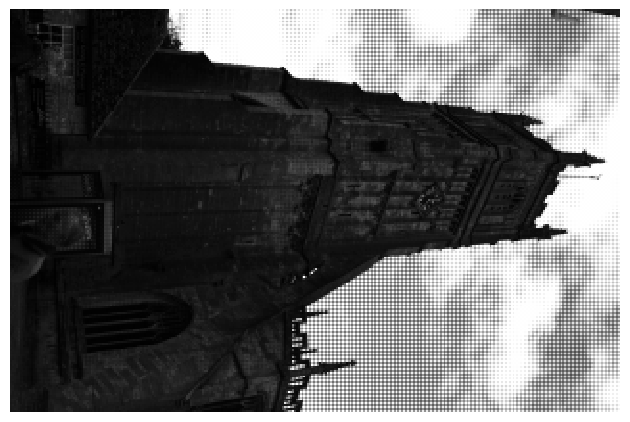

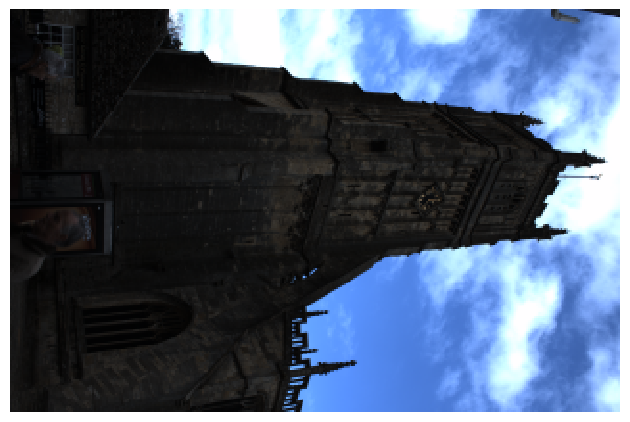

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [3]:
x, y = train_gen.__getitem__(0)
colour.plotting.plot_image(x[0])
colour.plotting.plot_image(y[0])

In [15]:
np.expand_dims(x[0], axis=-1).shape

(210, 318, 1)

In [20]:
from debayering.losses import color

#def main_loss(y_true, y_pred):
#    return tf.abs(y_true - y_pred)

def main_loss(y_true, y_pred):
    return tf.keras.losses.MAE(y_true, y_pred) + color(y_true, y_pred)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1.0)

In [21]:
from debayering.models import simple_conv

simple_conv_model = simple_conv.get_model_flat()
simple_conv_model.compile(optimizer='adam', loss=main_loss, metrics=[ssim, psnr])
simple_conv_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 8)     208       
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 16)    1168      
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 12)    1740      
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 3)     327       
                                                                 
Total params: 3,443
Trainable params: 3,443
Non-trainable params: 0
_________________________________________________________________


In [22]:
epochs = 20

history = simple_conv_model.fit(
    train_gen, 
    epochs=epochs, 
    validation_data=val_gen, 
    workers=8
)

Epoch 1/20
6/6 [==============================] - 5s 772ms/step - loss: 0.2653 - ssim: 0.3420 - psnr: 14.4121 - val_loss: 0.1449 - val_ssim: 0.6149 - val_psnr: 16.3082
Epoch 2/20
6/6 [==============================] - 4s 691ms/step - loss: 0.1269 - ssim: 0.5728 - psnr: 17.5334 - val_loss: 0.0862 - val_ssim: 0.7088 - val_psnr: 21.5619
Epoch 3/20
6/6 [==============================] - 4s 726ms/step - loss: 0.0903 - ssim: 0.5985 - psnr: 21.9085 - val_loss: 0.0789 - val_ssim: 0.6544 - val_psnr: 22.7905
Epoch 4/20
6/6 [==============================] - 5s 799ms/step - loss: 0.0902 - ssim: 0.5862 - psnr: 22.1912 - val_loss: 0.0721 - val_ssim: 0.6946 - val_psnr: 23.9191
Epoch 5/20
6/6 [==============================] - 5s 770ms/step - loss: 0.0820 - ssim: 0.6341 - psnr: 22.8998 - val_loss: 0.0701 - val_ssim: 0.7435 - val_psnr: 23.9040
Epoch 6/20
6/6 [==============================] - 5s 809ms/step - loss: 0.0762 - ssim: 0.6691 - psnr: 23.2641 - val_loss: 0.0567 - val_ssim: 0.7713 - val_psnr: 

1/1 [==============================] - 0s 116ms/step


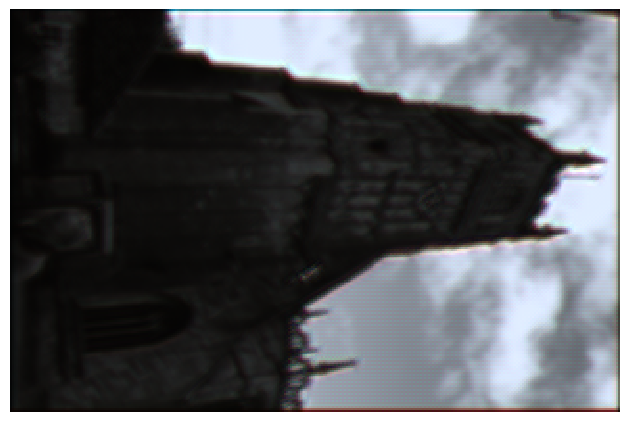

tf.Tensor(0.031659, shape=(), dtype=float32)
tf.Tensor(0.0119817, shape=(), dtype=float32)


In [23]:
simple_conv_model.evaluate(val_gen)
pred = simple_conv_model.predict(x)
colour.plotting.plot_image(pred[0])

print(tf.keras.losses.MeanAbsoluteError()(y, pred))
print(color(y, pred))

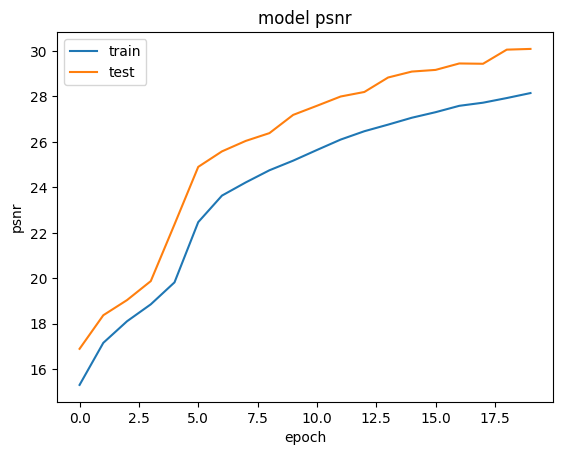

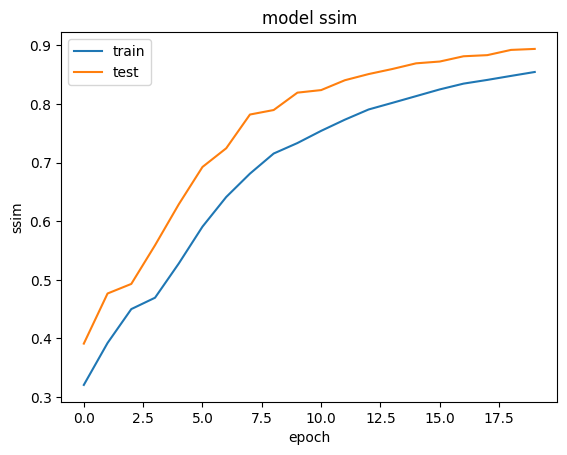

In [14]:
# summarize history for psnr
plt.plot(history.history['psnr'])
plt.plot(history.history['val_psnr'])
plt.title('model psnr')
plt.ylabel('psnr')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for ssim
plt.plot(history.history['ssim'])
plt.plot(history.history['val_ssim'])
plt.title('model ssim')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
from debayering.models import unet

unet_model = unet.get_model()
unet_model.compile(optimizer='adam', loss=main_loss, metrics=[ssim, psnr])
unet_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 4)]                                                              
                                                                                                  
 conv2d_33 (Conv2D)             (None, None, None,   296         ['input_5[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d_34 (Conv2D)             (None, None, None,   584         ['conv2d_33[0][0]']              
                                8)                                                          

In [18]:
epochs = 10

history = unet_model.fit(
    train_gen, 
    epochs=epochs, 
    validation_data=val_gen, 
    workers=8
)

Epoch 1/10
6/6 [==============================] - 10s 1s/step - loss: 0.5440 - ssim: 0.2210 - psnr: 13.4798 - val_loss: 0.2557 - val_ssim: 0.3227 - val_psnr: 14.0056
Epoch 2/10
6/6 [==============================] - 8s 1s/step - loss: 0.2252 - ssim: 0.3185 - psnr: 13.6643 - val_loss: 0.2030 - val_ssim: 0.3857 - val_psnr: 14.1219
Epoch 3/10
6/6 [==============================] - 9s 1s/step - loss: 0.1883 - ssim: 0.3528 - psnr: 13.7489 - val_loss: 0.1860 - val_ssim: 0.4155 - val_psnr: 14.1972
Epoch 4/10
6/6 [==============================] - 9s 1s/step - loss: 0.1764 - ssim: 0.3713 - psnr: 13.8066 - val_loss: 0.1779 - val_ssim: 0.4340 - val_psnr: 14.2526
Epoch 5/10
6/6 [==============================] - 9s 1s/step - loss: 0.1706 - ssim: 0.3815 - psnr: 13.8443 - val_loss: 0.1720 - val_ssim: 0.4437 - val_psnr: 14.2852
Epoch 6/10
6/6 [==============================] - 9s 1s/step - loss: 0.1667 - ssim: 0.3872 - psnr: 13.8665 - val_loss: 0.1685 - val_ssim: 0.4489 - val_psnr: 14.3048
Epoch 7/1

KeyboardInterrupt: 

1/1 [==============================] - 0s 138ms/step


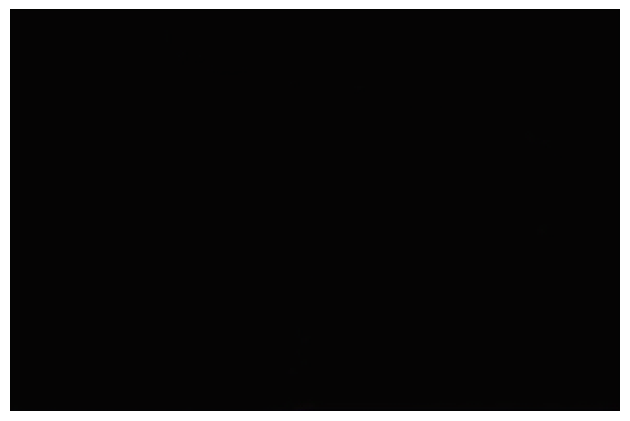

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [19]:
pred = unet_model.predict(x)
colour.plotting.plot_image(pred[0])

In [17]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, 
    Convolution2D,
)


def get_model(input_shape=(None, None, 4)): 
    inputs = Input(shape=input_shape)

    conv1 = Convolution2D(16, (3, 3), activation='tanh', padding='same')(inputs)
    conv2 = Convolution2D(16, (3, 3), activation='relu', padding='same')(conv1)
    conv3 = Convolution2D(12, (3, 3), activation='relu', padding='same')(conv2)
    x_out = tf.nn.depth_to_space(conv3, 2)
    return Model(inputs=inputs, outputs=x_out)

In [18]:
model = get_model()
model.compile(optimizer='adam', loss='mae', metrics=[ssim, psnr])
epochs = 10

history = unet_model.fit(
    train_gen, 
    epochs=epochs, 
    validation_data=val_gen, 
    workers=8
)

Epoch 1/10
6/6 [==============================] - 4s 602ms/step - loss: 0.0219 - ssim: 0.8503 - psnr: 28.1952 - val_loss: 0.0185 - val_ssim: 0.8925 - val_psnr: 29.6772
Epoch 2/10
6/6 [==============================] - 4s 614ms/step - loss: 0.0224 - ssim: 0.8562 - psnr: 28.0867 - val_loss: 0.0174 - val_ssim: 0.8979 - val_psnr: 30.1401
Epoch 3/10
6/6 [==============================] - 4s 602ms/step - loss: 0.0219 - ssim: 0.8573 - psnr: 28.1812 - val_loss: 0.0178 - val_ssim: 0.8977 - val_psnr: 30.1573
Epoch 4/10
6/6 [==============================] - 4s 595ms/step - loss: 0.0222 - ssim: 0.8547 - psnr: 28.3081 - val_loss: 0.0187 - val_ssim: 0.8800 - val_psnr: 29.9870
Epoch 5/10
6/6 [==============================] - 4s 634ms/step - loss: 0.0216 - ssim: 0.8587 - psnr: 28.4557 - val_loss: 0.0164 - val_ssim: 0.9001 - val_psnr: 30.4712
Epoch 6/10
6/6 [==============================] - 4s 661ms/step - loss: 0.0212 - ssim: 0.8621 - psnr: 28.5085 - val_loss: 0.0167 - val_ssim: 0.9019 - val_psnr: 

1/1 [==============================] - 0s 71ms/step


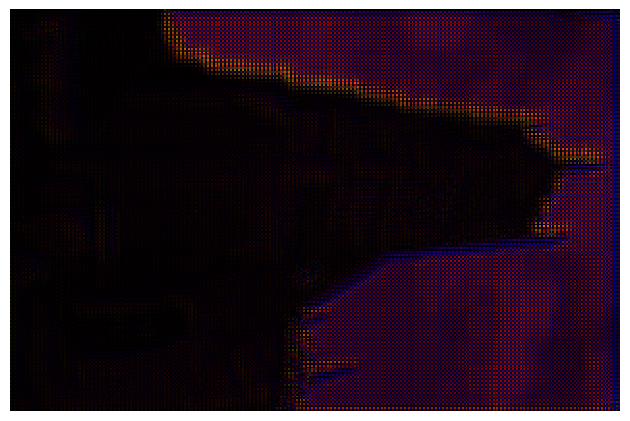

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [19]:
pred = model.predict(x)
colour.plotting.plot_image(pred[0])